# import required packages

In [1]:
import cv2
import math
import time
import matplotlib.pyplot as plt

# make the facebox function

In [2]:
def getFaceBox(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv2.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight / 150)), 8)
    return frameOpencvDnn, bboxes

# import face, age and gender files

In [3]:
faceProto = "opencv_face_detector.pbtxt"
faceModel = "opencv_face_detector_uint8.pb"

ageProto = "age_deploy.prototxt"
ageModel = "age_net.caffemodel"

genderProto = "gender_deploy.prototxt"
genderModel = "gender_net.caffemodel"

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = [
    "(0-2)",
    "(4-6)",
    "(8-12)",
    "(15-20)",
    "(25-32)",
    "(38-43)",
    "(48-53)",
    "(60-100)"
]

genderList = ["Male", "Female"]

In [4]:
ageNet = cv2.dnn.readNet(ageModel, ageProto)
genderNet = cv2.dnn.readNet(genderModel, genderProto)
faceNet = cv2.dnn.readNet(faceModel, faceProto)
padding = 20

# age_gender_detector function

In [5]:
def age_gender_detector(frame):
    t = time.time()
    frameFace, bboxes = getFaceBox(faceNet, frame)
    
    for bbox in bboxes:
        face = frame[max(0, bbox[1] - padding) : min(bbox[3] + padding, frame.shape[0] - 1),
                     max(0, bbox[0] - padding) : min(bbox[2] + padding, frame.shape[1] - 1)]

        blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        print("Gender : {}, conf = {:.3f}".format(gender, genderPreds[0].max()))

        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]
        print("Age : {}, conf = {:.3f}".format(age, agePreds[0].max()))

        label = "{} , {}".format(gender, age)
        cv2.putText(frameFace, label, (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA,)
    return frameFace

# final visualization of gender & age detection

Gender : Male, conf = 0.962
Age : (0-2), conf = 0.991


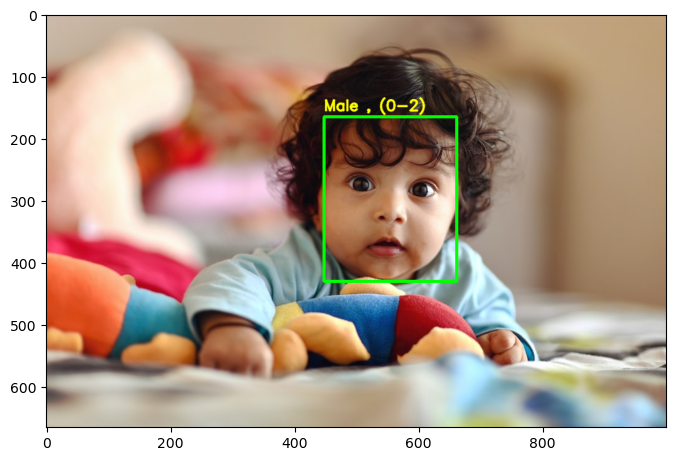

In [6]:
def show_results(img_path):
    img = cv2.imread(img_path)
    result = age_gender_detector(img)
    rgb_result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_result)
    plt.show()
show_results('Image1.jpeg')

Gender : Male, conf = 1.000
Age : (25-32), conf = 0.997


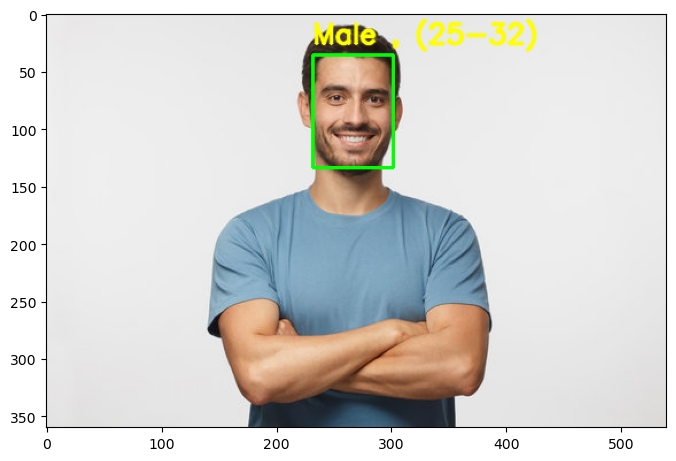

In [7]:
show_results('Image2.jpg')

Gender : Male, conf = 0.991
Age : (60-100), conf = 0.968


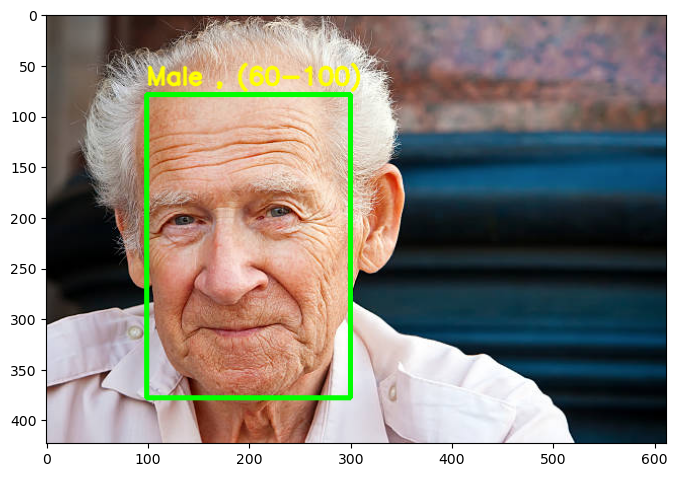

In [8]:
show_results('Image3.jpg')